In [2]:
import numpy as np # linear algebra
import pandas as pd 
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import filters, feature
from skimage.measure import shannon_entropy, moments, perimeter
import scipy.ndimage as ndi
import skimage.feature as feature
from skimage.io import imread, imshow
from skimage.color import rgb2gray
from scipy.stats import skew, kurtosis
import cv2 as cv

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifierCV
from sklearn import metrics
from sklearn import preprocessing

In [3]:
# Function converts signal to noise
def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

In [5]:
def edge_features(image2):
    # prewitt kernel
    pre_hor = filters.prewitt_h(image2)
    pre_ver = filters.prewitt_v(image2)

    # sobel kernel
    ed_sobel = filters.sobel(image2)

    # canny kernel
    can = feature.canny(image2)
    
    return pre_hor, pre_ver, ed_sobel, can

In [6]:
def texture_features(image1):
    # img = cv.imread(image1)
    gray = cv.cvtColor(image1, cv.COLOR_BGR2GRAY)

    # Finding the GLCM

    graycom = feature.graycomatrix(gray, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256)

    # Finding the GLCM properties
    contrast = feature.graycoprops(graycom, 'contrast')
    dissimilarity = feature.graycoprops(graycom, 'dissimilarity')
    homogeneity = feature.graycoprops(graycom, 'homogeneity')
    energy = feature.graycoprops(graycom, 'energy')
    correlation = feature.graycoprops(graycom, 'correlation')
    ASM = feature.graycoprops(graycom, 'ASM')
    
    glcm = np.squeeze(feature.graycomatrix(gray, distances=[1], 
                               angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], symmetric=True, 
                               normed=True))

    entropy = -np.sum(glcm*np.log2(glcm + (glcm==0)))
    shannon = shannon_entropy(gray)


    return contrast, dissimilarity, homogeneity, energy, correlation, ASM, entropy, shannon

In [7]:
def moments_features(image2):
    M = moments(image2)
#     print(M)
    area = M[0][0]
    cx = M[1, 0] / M[0, 0]
    cy = M[0, 1] / M[0, 0]
    centroid = (cx, cy)

#     print(area)
#     print(centroid)
    # eccentricity
    mu_20 = M[2, 0] / M[0, 0] - (cx ** 2)
    mu_02 = M[0, 2] / M[0, 0] - (cy ** 2)
    mu_11 = M[1, 1] / M[0, 0] - (cx * cy)

    e = (((mu_20 - mu_02) ** 2) + (4 * mu_11 ** 2)) / ((mu_20 + mu_02) ** 2)
#     print('Eccentricity = {}'.format(e))
    
    delta = np.sqrt(4 * mu_11 ** 2 + (mu_20 - mu_02) ** 2)

    lambda_1 = ((mu_20 + mu_02) + delta) / 2
    lambda_2 = ((mu_20 + mu_02) - delta) / 2

    major_length = np.sqrt(np.abs(lambda_1)) * 4
    minor_length = np.sqrt(np.abs(lambda_2)) * 4

#     print(major_length)
#     print(minor_length)

    return area, centroid, e, major_length, minor_length

### FEATURE ENGINEERING

#### Data Creation and Processing

In [8]:
# Create a dataframe with those features
df = pd.DataFrame(columns = ['pixel_feat', 'pre_hor', 'pre_ver', 'ed_sobel', 'can', 'contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM', 'entropy', 'shannon_entropy', 'area', 'centroid', 'eccentricity', 'major_length', 'minor_length', 'perimeter', 'mean', 'var', 'std', 'skewness', 'kurtosis', 'SNR'])
df


,pixel_feat,pre_hor,pre_ver,ed_sobel,can,contrast,dissimilarity,homogeneity,energy,correlation,...,eccentricity,major_length,minor_length,perimeter,mean,var,std,skewness,kurtosis,SNR


#### We load each picture into our file and extract features from them

In [ ]:
for dirname, _, filenames in os.walk('/Users/mac/Documents/PROJECTS/Chizzy/fresh_tomato'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        print(path)
        if path[-2] == 'n':
              continue
        image1 = imread(path) # Reads image in file path
        if len(image1.shape) == 2:
            continue
        image2 = rgb2gray(imread(path))
        print(image2.reshape(-1))
        shape = image2.shape
        pixel_feat = np.reshape(image2, shape) # Takes image pixel features
        pre_hor, pre_ver, ed_sobel, can = edge_features(image2) # Applies the edge_features function to image
        contrast, dissimilarity, homogeneity, energy, correlation, ASM, entropy, s_e = texture_features(image1)  # aApplies the texture_features function to image
        area, centroid, eccentricity, major_length, minor_length = moments_features(image2) # Applies the moments_features function to image
        SNR = signaltonoise(image2, axis = None)
        p = perimeter(image2)
        mean = np.mean(image2)
        var = ndi.variance(image2)
        std = ndi.standard_deviation(image2)
        s = skew(image2.reshape(-1))
        k = kurtosis(image2.reshape(-1))
        df.loc[len(df.index)] = [pixel_feat, pre_hor, pre_ver, ed_sobel, can, contrast, dissimilarity, homogeneity, energy, correlation,  ASM, entropy, s_e, area, centroid, eccentricity, major_length, minor_length, perimeter, mean, var, std, s, k, SNR]

In [ ]:
df['result'] = ['fresh'] * len(df) # add description to them: fresh or defective/stale
df.head(5)

In [ ]:
df.to_csv('fresh.csv') # Convert to CSV and save locally

In [10]:
# fresh = pd.read_csv('fresh.csv') # RUN THIS IF YOU ARE RE-RUNNING THE FILES

In [11]:
# stale = pd.read_csv('stale.csv') 

In [12]:
# df = fresh
# dg = stale

In [ ]:
for dirname, _, filenames in os.walk('/Users/mac/Documents/PROJECTS/Chizzy/stale_tomato'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        print(path)
        if path[-2] == 'n':
              continue
        image1 = imread(path)
        if len(image1.shape) == 2:
            continue
        image2 = rgb2gray(imread(path))
        print(image2.reshape(-1))
        shape = image2.shape
        pixel_feat = np.reshape(image2, shape)
        pre_hor, pre_ver, ed_sobel, can = edge_features(image2)
        contrast, dissimilarity, homogeneity, energy, correlation, ASM, entropy, s_e = texture_features(image1)
        area, centroid, eccentricity, major_length, minor_length = moments_features(image2)
        SNR = signaltonoise(image2, axis = None)
        p = perimeter(image2)
        mean = np.mean(image2)
        var = ndi.variance(image2)
        std = ndi.standard_deviation(image2)
        s = skew(image2.reshape(-1))
        k = kurtosis(image2.reshape(-1))
        df.loc[len(df.index)] = [pixel_feat, pre_hor, pre_ver, ed_sobel, can, contrast, dissimilarity, homogeneity, energy, correlation,  ASM, entropy, s_e, area, centroid, eccentricity, major_length, minor_length, perimeter, mean, var, std, s, k, SNR]

In [ ]:
dg['result'] = ['stale'] * len(dg) # add fresh or stale
dg.head(5)

In [ ]:
dg.to_csv('stale.csv') # Save as csv file

In [ ]:
dg.info()

#### We join both stale and fresh image data for both Tomatoes and Maize

In [105]:
fruit = pd.concat([dg, df], keys='result') # Join all datasets
fruit.info() # Checks dataset info

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1963 entries, ('r', 0) to ('e', 980)
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       1963 non-null   int64  
 1   pixel_feat       1963 non-null   object 
 2   pre_hor          1963 non-null   object 
 3   pre_ver          1963 non-null   object 
 4   ed_sobel         1963 non-null   object 
 5   can              1963 non-null   object 
 6   contrast         1963 non-null   object 
 7   dissimilarity    1963 non-null   object 
 8   homogeneity      1963 non-null   object 
 9   energy           1963 non-null   object 
 10  correlation      1963 non-null   object 
 11  ASM              1963 non-null   object 
 12  entropy          1963 non-null   float64
 13  shannon_entropy  1963 non-null   float64
 14  area             1963 non-null   float64
 15  centroid         1963 non-null   object 
 16  eccentricity     1963 non-null   float64
 17  m

In [11]:
fruit.to_csv('combineddata.csv')

#### Data Transformation Using LabelEncoder

In [119]:
le = preprocessing.LabelEncoder()
for column_name in fruit.columns:
    if fruit[column_name].dtype == object:
        fruit[column_name] = le.fit_transform(fruit[column_name].astype(str))
    else:
        pass
    
# We transformed all object data to useful data types using the label econder.
  

In [120]:
dt = fruit.copy() # We create a copy

In [121]:
dt.reset_index(inplace=True) # Reset index so you can remove unwanted columns

In [122]:
dt.drop(['level_0', 'level_1', 'Unnamed: 0'], axis=1, inplace=True) # drop columns with no use

In [123]:
X = dt.drop('result', axis = 1)
y = dt['result']  # Splt data into X and Y.

## Machine Learning

#### Train Test Split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, 
                                                    random_state=101)  # Divides the dataset into training half and testing half

In [125]:
dt.to_csv('encoded_tomato.csv')

#### LOGISTIC REGRESSION

In [21]:
logmodel = LogisticRegression() # Instantiates the logistic model

In [22]:
logmodel.fit(X_train,y_train) # Fits the logistic model to our dataset

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [23]:
Logpredictions = logmodel.predict(X_test) # Run predictions

In [24]:
print(classification_report(y_test,Logpredictions))

              precision    recall  f1-score   support

           0       0.79      0.85      0.82       293
           1       0.84      0.77      0.80       296

    accuracy                           0.81       589
   macro avg       0.81      0.81      0.81       589
weighted avg       0.81      0.81      0.81       589



In [25]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, Logpredictions, pos_label=1)

In [26]:
metrics.auc(fpr, tpr)

0.8117390000922424

,pixel_feat,pre_hor,pre_ver,ed_sobel,can,contrast,dissimilarity,homogeneity,energy,correlation,...,major_length,minor_length,perimeter,mean,var,std,skewness,kurtosis,SNR,result
0,1030,178,94,196,0,1819,1619,709,454,1361,...,460.966291,447.168033,0,0.782071,0.016637,0.128984,-0.576950,-1.489935,1246,0
1,1369,177,94,221,0,1669,1712,310,150,664,...,552.123811,507.808152,0,0.806557,0.006167,0.078531,-0.717294,-0.601939,59,0
2,1351,299,94,93,0,1259,1061,1099,1984,680,...,553.814157,468.814133,0,0.810320,0.008563,0.092535,-0.643791,-1.175462,1770,0
3,1087,22,94,119,0,1866,1863,184,1510,1061,...,498.810061,471.558365,0,0.772763,0.011784,0.108556,-1.107824,0.096908,1412,0
4,1698,277,94,123,0,2013,2021,16,937,1674,...,521.848816,519.809535,0,0.811999,0.021339,0.146079,-0.673991,-1.000614,1184,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2033,839,269,94,8,0,498,598,1250,989,1077,...,586.271263,488.942082,0,0.802276,0.001460,0.038210,-1.089751,0.729422,1081,1
2034,301,269,94,8,0,324,307,1689,1836,411,...,660.841893,506.649238,0,0.701616,0.003064,0.055351,-0.796670,-0.427353,529,1
2035,894,176,46,258,0,0,2029,23,36,862,...,511.923353,437.789109,0,0.816342,0.010964,0.104710,-0.333472,-0.704867,1553,1
2036,1928,32,94,19,0,1627,1481,643,1195,1695,...,622.919308,493.692567,0,0.894526,0.008316,0.091190,-0.682384,-1.014448,1992,1


#### K-NN

In [27]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train,y_train)
Kpred = knn.predict(X_test)
print(classification_report(y_test,Kpred))

              precision    recall  f1-score   support

           0       0.89      0.92      0.90       293
           1       0.92      0.88      0.90       296

    accuracy                           0.90       589
   macro avg       0.90      0.90      0.90       589
weighted avg       0.90      0.90      0.90       589



/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [28]:
# Runs the KNN for several values of K, taking the errors

error_rate = []
for i in range(1,50):
    KNN = KNeighborsClassifier(n_neighbors=i)
    KNN.fit(X_train,y_train)
    pred_i = KNN.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be ac

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be ac

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be ac

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be ac

Text(0, 0.5, 'Error Rate')

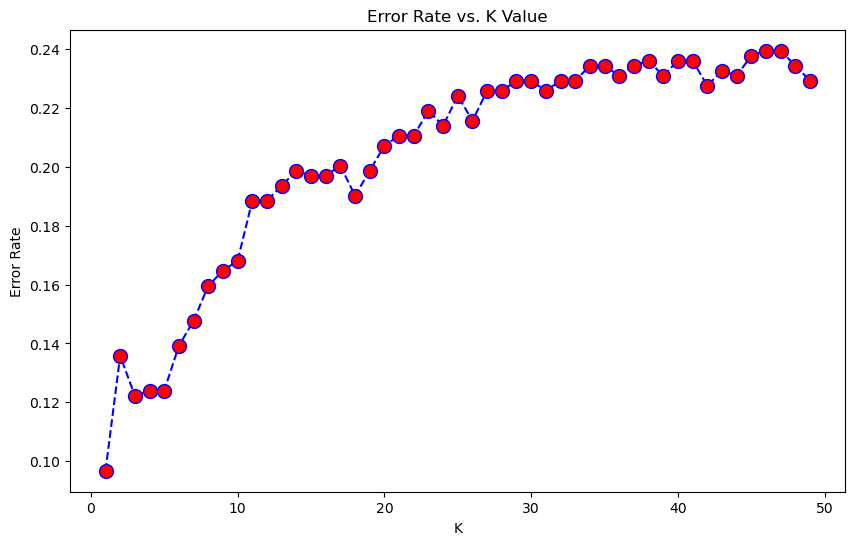

In [28]:
plt.figure(figsize=(10,6))
plt.plot(range(1,50),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [29]:
# At K = 45, 
knn = KNeighborsClassifier(n_neighbors=45)
knn.fit(X_train,y_train)
Kpred = knn.predict(X_test)
print(classification_report(y_test,Kpred))

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


              precision    recall  f1-score   support

           0       0.76      0.76      0.76       293
           1       0.76      0.77      0.76       296

    accuracy                           0.76       589
   macro avg       0.76      0.76      0.76       589
weighted avg       0.76      0.76      0.76       589



In [30]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, Kpred, pos_label=1)
metrics.auc(fpr, tpr)

0.7622855363896319

#### DECISION TREES 

In [31]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)
dpred = dtree.predict(X_test)
print(classification_report(y_test,dpred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       293
           1       0.96      0.94      0.95       296

    accuracy                           0.95       589
   macro avg       0.95      0.95      0.95       589
weighted avg       0.95      0.95      0.95       589



In [32]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, dpred, pos_label=1)
metrics.auc(fpr, tpr) # Area under curve

0.9457211050641086

#### RANDOM FOREST

In [33]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)
print(classification_report(y_test,rfc_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       293
           1       0.99      0.98      0.99       296

    accuracy                           0.99       589
   macro avg       0.99      0.99      0.99       589
weighted avg       0.99      0.99      0.99       589



In [34]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, rfc_pred, pos_label=1)
metrics.auc(fpr, tpr)

0.98307351720321

#### Support Vector Machines

In [34]:
model = SVC()
model.fit(X_train,y_train)
SVpred = model.predict(X_test)
print(classification_report(y_test,SVpred))

              precision    recall  f1-score   support

           0       0.60      0.88      0.72       293
           1       0.79      0.43      0.55       296

    accuracy                           0.65       589
   macro avg       0.70      0.65      0.64       589
weighted avg       0.70      0.65      0.63       589



In [35]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, SVpred, pos_label=1)
metrics.auc(fpr, tpr)

0.6548173600221383

#### Parameter Tuning

In [36]:
# We set our parameters with the grid
param_grid = {'C': [0.0001,0.001,0.01,0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001, 0.00001, 0.000001, 0.0000001], 'kernel': ['rbf']} 

In [37]:
from sklearn.model_selection import GridSearchCV

In [38]:
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=3) # We fit the parameters to our SVC

In [39]:
grid.fit(X_train,y_train) # We train on data

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END .....C=0.0001, gamma=1, kernel=rbf;, score=0.498 total time=   0.2s
[CV 2/5] END .....C=0.0001, gamma=1, kernel=rbf;, score=0.502 total time=   0.2s
[CV 3/5] END .....C=0.0001, gamma=1, kernel=rbf;, score=0.502 total time=   0.3s
[CV 4/5] END .....C=0.0001, gamma=1, kernel=rbf;, score=0.502 total time=   0.3s
[CV 5/5] END .....C=0.0001, gamma=1, kernel=rbf;, score=0.500 total time=   0.3s
[CV 1/5] END ...C=0.0001, gamma=0.1, kernel=rbf;, score=0.498 total time=   0.2s
[CV 2/5] END ...C=0.0001, gamma=0.1, kernel=rbf;, score=0.502 total time=   0.2s
[CV 3/5] END ...C=0.0001, gamma=0.1, kernel=rbf;, score=0.502 total time=   0.1s
[CV 4/5] END ...C=0.0001, gamma=0.1, kernel=rbf;, score=0.502 total time=   0.2s
[CV 5/5] END ...C=0.0001, gamma=0.1, kernel=rbf;, score=0.500 total time=   0.2s
[CV 1/5] END ..C=0.0001, gamma=0.01, kernel=rbf;, score=0.498 total time=   0.2s
[CV 2/5] END ..C=0.0001, gamma=0.01, kernel=rbf

[CV 2/5] END ..C=0.01, gamma=0.0001, kernel=rbf;, score=0.502 total time=   0.4s
[CV 3/5] END ..C=0.01, gamma=0.0001, kernel=rbf;, score=0.502 total time=   0.3s
[CV 4/5] END ..C=0.01, gamma=0.0001, kernel=rbf;, score=0.502 total time=   0.2s
[CV 5/5] END ..C=0.01, gamma=0.0001, kernel=rbf;, score=0.500 total time=   0.3s
[CV 1/5] END ...C=0.01, gamma=1e-05, kernel=rbf;, score=0.498 total time=   0.3s
[CV 2/5] END ...C=0.01, gamma=1e-05, kernel=rbf;, score=0.502 total time=   0.4s
[CV 3/5] END ...C=0.01, gamma=1e-05, kernel=rbf;, score=0.502 total time=   0.3s
[CV 4/5] END ...C=0.01, gamma=1e-05, kernel=rbf;, score=0.502 total time=   0.2s
[CV 5/5] END ...C=0.01, gamma=1e-05, kernel=rbf;, score=0.500 total time=   0.2s
[CV 1/5] END ...C=0.01, gamma=1e-06, kernel=rbf;, score=0.498 total time=   0.2s
[CV 2/5] END ...C=0.01, gamma=1e-06, kernel=rbf;, score=0.502 total time=   0.3s
[CV 3/5] END ...C=0.01, gamma=1e-06, kernel=rbf;, score=0.502 total time=   0.2s
[CV 4/5] END ...C=0.01, gamm

[CV 5/5] END .........C=10, gamma=1, kernel=rbf;, score=0.500 total time=   0.3s
[CV 1/5] END .......C=10, gamma=0.1, kernel=rbf;, score=0.498 total time=   0.3s
[CV 2/5] END .......C=10, gamma=0.1, kernel=rbf;, score=0.502 total time=   0.2s
[CV 3/5] END .......C=10, gamma=0.1, kernel=rbf;, score=0.502 total time=   0.2s
[CV 4/5] END .......C=10, gamma=0.1, kernel=rbf;, score=0.502 total time=   0.2s
[CV 5/5] END .......C=10, gamma=0.1, kernel=rbf;, score=0.500 total time=   0.2s
[CV 1/5] END ......C=10, gamma=0.01, kernel=rbf;, score=0.498 total time=   0.2s
[CV 2/5] END ......C=10, gamma=0.01, kernel=rbf;, score=0.502 total time=   0.2s
[CV 3/5] END ......C=10, gamma=0.01, kernel=rbf;, score=0.502 total time=   0.3s
[CV 4/5] END ......C=10, gamma=0.01, kernel=rbf;, score=0.502 total time=   0.5s
[CV 5/5] END ......C=10, gamma=0.01, kernel=rbf;, score=0.500 total time=   0.3s
[CV 1/5] END .....C=10, gamma=0.001, kernel=rbf;, score=0.498 total time=   0.2s
[CV 2/5] END .....C=10, gamm

KeyboardInterrupt: 

In [41]:
grid.best_params_ # Best parameters

{'C': 1000, 'gamma': 1e-07, 'kernel': 'rbf'}

In [42]:
grid.best_estimator_ # Best estimators

SVC(C=1000, gamma=1e-07)

In [43]:
grid_predictions = grid.predict(X_test) # Predictions are made with the best parametrs

In [44]:
print(confusion_matrix(y_test,grid_predictions))

[[284   9]
 [ 17 279]]


In [45]:
print(classification_report(y_test,grid_predictions))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       293
           1       0.97      0.94      0.96       296

    accuracy                           0.96       589
   macro avg       0.96      0.96      0.96       589
weighted avg       0.96      0.96      0.96       589



In [46]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, grid_predictions, pos_label=1)
metrics.auc(fpr, tpr)

0.9559254220090397

#### MODEL EVALUATION SUMMARY

In [40]:


Model_dict = {'Logistic Regression':[0.81, 0.81, 0.81, 0.81],
              'KNN': [0.90, 0.90, 0.90, 0.90],
              'Decision Trees': [0.95, 0.95, 0.95, 0.94],
              'Random Forest': [0.98, 0.98, 0.98, 0.98],
              'SVM': [0.96, 0.96, 0.96, 0.95]}

In [41]:
# We create a dataframe with all the models results

Results = pd.DataFrame(Model_dict.values(), index=['Logistic Regression', 'KNN', 'Decision Trees', 'Random Forest', 'SVM'], columns=['Precision', 'Recall', 'F1-Score', 'AUC'])

Text(0.5, 1.0, 'Overview of Model Performance on Data')

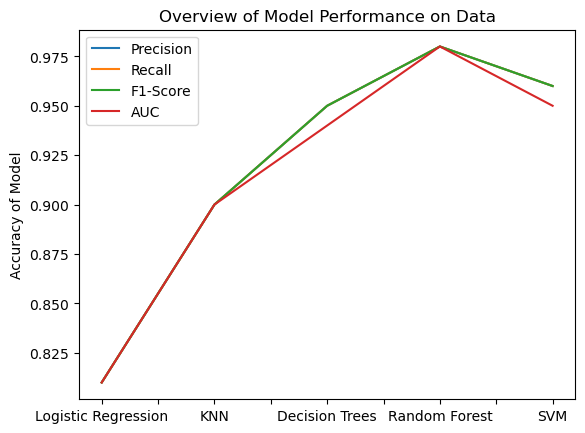

In [42]:
Results.plot.line()
plt.ylabel('Accuracy of Model')
plt.title('Overview of Model Performance on Data')

Text(0.5, 1.0, 'Overview of Model Performance on Data')

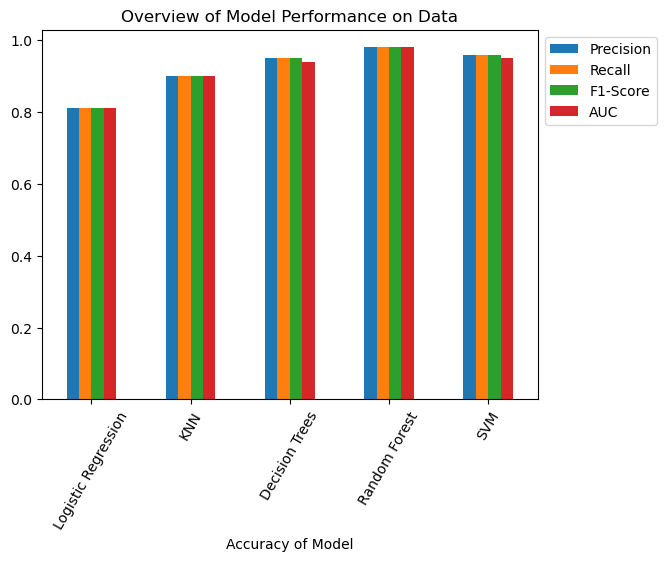

In [43]:
Results.plot.bar()
plt.xlabel('Accuracy of Model')
plt.xticks(rotation= 60)
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.title('Overview of Model Performance on Data')

## MAIZE DEFECT DETECTION 

In [46]:
dx = pd.DataFrame(columns = ['pixel_feat', 'pre_hor', 'pre_ver', 'ed_sobel', 'can', 'contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM', 'entropy', 'shannon_entropy', 'area', 'centroid', 'eccentricity', 'major_length', 'minor_length', 'perimeter', 'mean', 'var', 'std', 'skewness', 'kurtosis', 'SNR'])
dx

,pixel_feat,pre_hor,pre_ver,ed_sobel,can,contrast,dissimilarity,homogeneity,energy,correlation,...,eccentricity,major_length,minor_length,perimeter,mean,var,std,skewness,kurtosis,SNR


In [47]:
for dirname, _, filenames in os.walk('/Users/mac/Documents/PROJECTS/Chizzy/bad_maize'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        print(path)
        if path[-2] == 'n':
              continue
        image1 = imread(path)
        if len(image1.shape) == 2:
            continue
        image2 = rgb2gray(imread(path))
        print(image2.reshape(-1))
        shape = image2.shape
        pixel_feat = np.reshape(image2, shape)
        pre_hor, pre_ver, ed_sobel, can = edge_features(image2)
        contrast, dissimilarity, homogeneity, energy, correlation, ASM, entropy, s_e = texture_features(image1)
        area, centroid, eccentricity, major_length, minor_length = moments_features(image2)
        SNR = signaltonoise(image2, axis = None)
        p = perimeter(image2)
        mean = np.mean(image2)
        var = ndi.variance(image2)
        std = ndi.standard_deviation(image2)
        s = skew(image2.reshape(-1))
        k = kurtosis(image2.reshape(-1))
        dx.loc[len(dx.index)] = [pixel_feat, pre_hor, pre_ver, ed_sobel, can, contrast, dissimilarity, homogeneity, energy, correlation,  ASM, entropy, s_e, area, centroid, eccentricity, major_length, minor_length, perimeter, mean, var, std, s, k, SNR]

/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 291.jpg
[0.85799725 0.85799725 0.85799725 ... 0.90196078 0.90196078 0.90196078]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 285.jpg
[0.90537725 0.90537725 0.90537725 ... 0.85047529 0.85047529 0.85047529]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 508.jpg
[0.90196078 0.90196078 0.90196078 ... 0.88710078 0.88710078 0.88710078]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 534.jpg
[0.86224   0.86224   0.86224   ... 0.8547251 0.8547251 0.8547251]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 252.jpg
[0.94459294 0.94459294 0.94459294 ... 0.94459294 0.94459294 0.94459294]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 246.jpg
[0.85047529 0.85047529 0.85047529 ... 0.87792627 0.87792627 0.87792627]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 520.jpg
[0.8745098  0.8745098  0.8745098  ... 0.90196078 0.90196078 0.90196078]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 911.jpg
[0.9877302 0.9

/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 284.jpg
[0.93282824 0.93282824 0.93282824 ... 0.94521098 0.94521098 0.94521098]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 290.jpg
[0.86224    0.86224    0.86224    ... 0.98833333 0.98833333 0.98833333]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 286.jpg
[0.89394078 0.89394078 0.89394078 ... 0.94459294 0.94459294 0.94459294]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 292.jpg
[0.84364235 0.84364235 0.84364235 ... 0.84705882 0.84705882 0.84705882]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 279.jpg
[0.92941176 0.92941176 0.92941176 ... 0.84705882 0.84705882 0.84705882]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 523.jpg
[0.90196078 0.90196078 0.90196078 ... 0.91372549 0.91372549 0.91372549]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 245.jpg
[0.88544824 0.88544824 0.88544824 ... 0.96780118 0.96780118 0.96780118]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 251.jpg
[0.74901

/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 536.jpg
[0.9403502  0.9403502  0.9403502  ... 0.92858549 0.92858549 0.92858549]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 522.jpg
[0.94117647 0.94117647 0.94117647 ... 0.94117647 0.94117647 0.94117647]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 244.jpg
[0.97629373 0.97629373 0.97629373 ... 0.86224    0.86224    0.86224   ]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 278.jpg
[0.91372549 0.91372549 0.91372549 ... 0.88627451 0.88627451 0.88627451]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 293.jpg
[0.92139176 0.92139176 0.92139176 ... 0.90962706 0.90962706 0.90962706]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 287.jpg
[0.83903882 0.83903882 0.83903882 ... 0.83478902 0.83478902 0.83478902]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 283.jpg
[0.95686275 0.95686275 0.95686275 ... 0.92941176 0.92941176 0.92941176]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 297.jpg
[0.94117

/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 902.jpg
[0.74492118 0.74492118 0.74492118 ... 0.68576941 0.68576941 0.68576941]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 269.jpg
[0.95686275 0.95686275 0.95686275 ... 0.9403502  0.9403502  0.9403502 ]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 533.jpg
[0.95664745 0.95664745 0.95664745 ... 0.95664745 0.95664745 0.95664745]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 255.jpg
[0.74901961 0.74901961 0.74901961 ... 0.79215686 0.79215686 0.79215686]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 241.jpg
[0.81878157 0.81878157 0.81878157 ... 0.77564431 0.77564431 0.77564431]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 527.jpg
[0.97629373 0.97629373 0.97629373 ... 0.98665176 0.98665176 0.98665176]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 296.jpg
[0.77988706 0.77988706 0.77988706 ... 0.83903882 0.83903882 0.83903882]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 282.jpg
[0.94884

/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 901.jpg
[0.8745098 0.8745098 0.8745098 ... 0.8745098 0.8745098 0.8745098]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 915.jpg
[0.84705882 0.84705882 0.84705882 ... 0.85882353 0.85882353 0.85882353]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 929.jpg
[0.85882353 0.85882353 0.85882353 ... 0.90196078 0.90196078 0.90196078]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 518.jpg
[0.83478902 0.83478902 0.83478902 ... 0.87792627 0.87792627 0.87792627]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 524.jpg
[0.79557333 0.79557333 0.79557333 ... 0.7805051  0.7805051  0.7805051 ]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 242.jpg
[0.82727412 0.82727412 0.82727412 ... 0.82727412 0.82727412 0.82727412]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 256.jpg
[0.93707804 0.93707804 0.93707804 ... 0.90962706 0.90962706 0.90962706]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 530.jpg
[0.96027922 0.

/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 807.jpg
[0.84705882 0.84705882 0.84705882 ... 0.81960784 0.81960784 0.81960784]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 1011.jpg
[0.87792627 0.87792627 0.87792627 ... 0.85047529 0.85047529 0.85047529]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 740.jpg
[0.83478902 0.83478902 0.83478902 ... 0.88217608 0.88217608 0.88217608]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 998.jpg
[0.9403502 0.9403502 0.9403502 ... 0.9403502 0.9403502 0.9403502]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 754.jpg
[0.80309529 0.80309529 0.80309529 ... 0.80309529 0.80309529 0.80309529]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 1005.jpg
[0.77647059 0.77647059 0.77647059 ... 0.78874039 0.78874039 0.78874039]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 768.jpg
[0.81960784 0.81960784 0.81960784 ... 0.76470588 0.76470588 0.76470588]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 783.jpg
[0.7372549  

/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 637.jpg
[0.91289922 0.91289922 0.91289922 ... 0.87368353 0.87368353 0.87368353]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 151.jpg
[0.90196078 0.90196078 0.90196078 ... 0.95686275 0.95686275 0.95686275]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 179.jpg
[0.74901961 0.74901961 0.74901961 ... 0.77647059 0.77647059 0.77647059]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 186.jpg
[0.98665176 0.98665176 0.98665176 ... 0.88969098 0.88969098 0.88969098]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 838.jpg
[0.79215686 0.79215686 0.79215686 ... 0.84705882 0.84705882 0.84705882]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 192.jpg
[0.94117647 0.94117647 0.94117647 ... 0.9403502  0.9403502  0.9403502 ]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 804.jpg
[0.85882353 0.85882353 0.85882353 ... 0.87792627 0.87792627 0.87792627]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 810.jpg
[0.69411

/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 16.jpg
[0.79982314 0.79982314 0.79982314 ... 0.75751216 0.75751216 0.75751216]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 430.jpg
[0.86224    0.86224    0.86224    ... 0.92139176 0.92139176 0.92139176]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 356.jpg
[0.88627451 0.88627451 0.88627451 ... 0.88627451 0.88627451 0.88627451]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 381.jpg
[0.72156863 0.72156863 0.72156863 ... 0.7372549  0.7372549  0.7372549 ]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 395.jpg
[0.88217608 0.88217608 0.88217608 ... 0.88969098 0.88969098 0.88969098]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 168.jpg
[0.68576941 0.68576941 0.68576941 ... 0.76812235 0.76812235 0.76812235]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 626.jpg
[0.83137255 0.83137255 0.83137255 ... 0.79215686 0.79215686 0.79215686]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 140.jpg
[0.874509

/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 340.jpg
[0.8547251  0.8547251  0.8547251  ... 0.88217608 0.88217608 0.88217608]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 354.jpg
[0.77647059 0.77647059 0.77647059 ... 0.76470588 0.76470588 0.76470588]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 432.jpg
[0.79215686 0.79215686 0.79215686 ... 0.83137255 0.83137255 0.83137255]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 28.jpg
[0.90962706 0.90962706 0.90962706 ... 0.89394078 0.89394078 0.89394078]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 368.jpg
[0.79557333 0.79557333 0.79557333 ... 0.76449059 0.76449059 0.76449059]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 369.jpg
[0.87792627 0.87792627 0.87792627 ... 0.86224    0.86224    0.86224   ]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 29.jpg
[0.82727412 0.82727412 0.82727412 ... 0.8547251  0.8547251  0.8547251 ]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 355.jpg
[0.7215686

[0.90620353 0.90620353 0.90620353 ... 0.90537725 0.90537725 0.90537725]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 364.jpg
[0.80733804 0.80733804 0.80733804 ... 0.83903882 0.83903882 0.83903882]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 402.jpg
[0.94117647 0.94117647 0.94117647 ... 0.92941176 0.92941176 0.92941176]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 30.jpg
[0.93707804 0.93707804 0.93707804 ... 0.94884275 0.94884275 0.94884275]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 416.jpg
[0.91372549 0.91372549 0.91372549 ... 0.94117647 0.94117647 0.94117647]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 24.jpg
[0.8664898  0.8664898  0.8664898  ... 0.85047529 0.85047529 0.85047529]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 370.jpg
[0.95603647 0.95603647 0.95603647 ... 0.88627451 0.88627451 0.88627451]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 25.jpg
[0.88969098 0.88969098 0.88969098 ... 0.94884275 0.94884275 0.94884275]


/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 33.jpg
[0.96452902 0.96452902 0.96452902 ... 0.92139176 0.92139176 0.92139176]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 367.jpg
[0.79557333 0.79557333 0.79557333 ... 0.76470588 0.76470588 0.76470588]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 32.jpg
[0.96452902 0.96452902 0.96452902 ... 0.94884275 0.94884275 0.94884275]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 400.jpg
[0.9403502  0.9403502  0.9403502  ... 0.92858549 0.92858549 0.92858549]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 366.jpg
[0.76470588 0.76470588 0.76470588 ... 0.76470588 0.76470588 0.76470588]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 372.jpg
[0.85882353 0.85882353 0.85882353 ... 0.88544824 0.88544824 0.88544824]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 26.jpg
[0.93707804 0.93707804 0.93707804 ... 0.94884275 0.94884275 0.94884275]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 414.jpg
[0.88217608

/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 405.jpg
[0.94884275 0.94884275 0.94884275 ... 0.96452902 0.96452902 0.96452902]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 37.jpg
[0.94884275 0.94884275 0.94884275 ... 0.96452902 0.96452902 0.96452902]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 411.jpg
[0.76470588 0.76470588 0.76470588 ... 0.74901961 0.74901961 0.74901961]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 23.jpg
[0.93707804 0.93707804 0.93707804 ... 0.96452902 0.96452902 0.96452902]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 377.jpg
[0.94884275 0.94884275 0.94884275 ... 0.96452902 0.96452902 0.96452902]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 388.jpg
[0.92919647 0.92919647 0.92919647 ... 0.94521098 0.94521098 0.94521098]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 149.jpg
[0.91289922 0.91289922 0.91289922 ... 0.87368353 0.87368353 0.87368353]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 607.jpg
[0.7913305

/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 360.jpg
[0.88544824 0.88544824 0.88544824 ... 0.90113451 0.90113451 0.90113451]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 638.jpg
[0.92139176 0.92139176 0.92139176 ... 0.89394078 0.89394078 0.89394078]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 610.jpg
[0.90537725 0.90537725 0.90537725 ... 0.94459294 0.94459294 0.94459294]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 176.jpg
[0.76470588 0.76470588 0.76470588 ... 0.80392157 0.80392157 0.80392157]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 162.jpg
[0.61445608 0.61445608 0.61445608 ... 0.81960784 0.81960784 0.81960784]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 604.jpg
[0.77647059 0.77647059 0.77647059 ... 0.83137255 0.83137255 0.83137255]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 837.jpg
[0.8745098  0.8745098  0.8745098  ... 0.92919647 0.92919647 0.92919647]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 189.jpg
[0.84623

[0.92139176 0.92139176 0.92139176 ... 0.93707804 0.93707804 0.93707804]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 91.jpg
[0.94884275 0.94884275 0.94884275 ... 0.90962706 0.90962706 0.90962706]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 676.jpg
[0.84623255 0.84623255 0.84623255 ... 0.83054627 0.83054627 0.83054627]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 110.jpg
[0.92941176 0.92941176 0.92941176 ... 0.85882353 0.85882353 0.85882353]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 104.jpg
[0.90962706 0.90962706 0.90962706 ... 0.87792627 0.87792627 0.87792627]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 662.jpg
[0.85882353 0.85882353 0.85882353 ... 0.92599529 0.92599529 0.92599529]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 892.jpg
[0.76470588 0.76470588 0.76470588 ... 0.79215686 0.79215686 0.79215686]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 138.jpg
[0.94884275 0.94884275 0.94884275 ... 0.93707804 0.93707804 0.93707804

/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 92.jpg
[0.83561529 0.83561529 0.83561529 ... 0.8664898  0.8664898  0.8664898 ]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 86.jpg
[0.94884275 0.94884275 0.94884275 ... 0.94459294 0.94459294 0.94459294]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 488.jpg
[0.80370627 0.80370627 0.80370627 ... 0.82302431 0.82302431 0.82302431]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 661.jpg
[0.88627451 0.88627451 0.88627451 ... 0.87792627 0.87792627 0.87792627]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 107.jpg
[0.86224 0.86224 0.86224 ... 0.86224 0.86224 0.86224]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 113.jpg
[0.60890549 0.60498392 0.60106235 ... 0.95603647 0.95603647 0.95603647]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 675.jpg
[0.83478902 0.83478902 0.83478902 ... 0.83478902 0.83478902 0.83478902]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 885.jpg
[0.84705882 0.84705882 0.847

/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 97.jpg
[0.94884275 0.94884275 0.94884275 ... 0.96452902 0.96452902 0.96452902]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 83.jpg
[0.93707804 0.93707804 0.93707804 ... 0.93707804 0.93707804 0.93707804]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 880.jpg
[0.88217608 0.88217608 0.88217608 ... 0.86224    0.86224    0.86224   ]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 658.jpg
[0.84623255 0.84623255 0.84623255 ... 0.85799725 0.85799725 0.85799725]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 894.jpg
[0.91372549 0.91372549 0.91372549 ... 0.93298941 0.93465608 0.93268392]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 102.jpg
[0.83137255 0.83137255 0.83137255 ... 0.81960784 0.81960784 0.81960784]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 664.jpg
[0.90196078 0.90196078 0.90196078 ... 0.91372549 0.91372549 0.91372549]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 670.jpg
[0.9488427

/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 80.jpg
[0.75243608 0.75243608 0.75243608 ... 0.67433294 0.67433294 0.67433294]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 94.jpg
[0.94459294 0.94459294 0.94459294 ... 0.94884275 0.94884275 0.94884275]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 129.jpg
[0.82302431 0.82302431 0.82302431 ... 0.82727412 0.82727412 0.82727412]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 897.jpg
[0.9403502 0.9403502 0.9403502 ... 0.9403502 0.9403502 0.9403502]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 883.jpg
[0.84623255 0.84623255 0.84623255 ... 0.80392157 0.80392157 0.80392157]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 115.jpg
[0.94459294 0.94459294 0.94459294 ... 0.96027922 0.96027922 0.96027922]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 673.jpg
[0.93707804 0.93707804 0.93707804 ... 0.94884275 0.94884275 0.94884275]
/Users/mac/Documents/PROJECTS/Chizzy/bad_maize/page1 667.jpg
[0.74819333 0.74

In [49]:
dx

,pixel_feat,pre_hor,pre_ver,ed_sobel,can,contrast,dissimilarity,homogeneity,energy,correlation,...,eccentricity,major_length,minor_length,perimeter,mean,var,std,skewness,kurtosis,SNR
0,"[[0.8579972549019608, 0.8579972549019608, 0.85...","[[-1.1102230246251565e-16, -1.1102230246251565...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[3.925231146709437e-17, 3.925231146709437e-17...","[[False, False, False, False, False, False, Fa...","[[3.171720575022454, 5.949138944212609, 2.9375...","[[0.5892155211141056, 0.9786477870127298, 0.57...","[[0.8518475845203005, 0.7739703477074296, 0.85...","[[0.20665957329370802, 0.19346490348133524, 0....","[[0.9989559261512428, 0.9980434285932936, 0.99...",...,0.000923,460.966291,447.168033,<function perimeter at 0x7f92855adf70>,0.782071,0.016637,0.128984,-0.576950,-1.489935,6.06330551367427
1,"[[0.9053772549019607, 0.9053772549019607, 0.90...","[[-1.1102230246251565e-16, -1.1102230246251565...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[3.925231146709437e-17, 3.925231146709437e-17...","[[False, False, False, False, False, False, Fa...","[[2.8873024371864338, 5.413683630022326, 2.321...","[[0.6141253693457863, 1.0031647927979797, 0.55...","[[0.827916039809517, 0.7460555079441236, 0.839...","[[0.17650452971205619, 0.16736732690203723, 0....","[[0.9986307902443312, 0.9974344074377973, 0.99...",...,0.006968,552.123811,507.808152,<function perimeter at 0x7f92855adf70>,0.806557,0.006167,0.078531,-0.717294,-0.601939,10.270501777428613
2,"[[0.9019607843137255, 0.9019607843137255, 0.90...","[[1.1102230246251565e-16, 1.1102230246251565e-...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.015686...","[[1.9626155733547187e-17, 1.9626155733547187e-...","[[False, False, False, False, False, False, Fa...","[[2.3750892219843, 4.331087198113488, 2.722600...","[[0.49360846148854387, 0.8237334995798671, 0.5...","[[0.8671299724343257, 0.7929793968397735, 0.85...","[[0.37651691212127875, 0.3652246518167217, 0.3...","[[0.9986383797914968, 0.9975190659027693, 0.99...",...,0.027257,553.814157,468.814133,<function perimeter at 0x7f92855adf70>,0.810320,0.008563,0.092535,-0.643791,-1.175462,8.756885024488465
3,"[[0.86224, 0.86224, 0.86224, 0.86224, 0.86224,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.011764...","[[1.9626155733547187e-17, 1.9626155733547187e-...","[[False, False, False, False, False, False, Fa...","[[3.2606976688122544, 6.633370593033424, 3.907...","[[0.6769725898604338, 1.1048971330171273, 0.72...","[[0.8160804676777038, 0.7375574102027552, 0.81...","[[0.2931641989926763, 0.2821590806600146, 0.29...","[[0.9988393763100237, 0.9976410946669972, 0.99...",...,0.003150,498.810061,471.558365,<function perimeter at 0x7f92855adf70>,0.772763,0.011784,0.108556,-1.107824,0.096908,7.11854210419555
4,"[[0.9445929411764705, 0.9445929411764705, 0.94...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.9626155733547187e-17, 1.9626155733547187e-...","[[False, False, False, False, False, False, Fa...","[[4.216958838188486, 7.950473996156362, 3.7352...","[[0.8388974821689408, 1.3335953187159866, 0.81...","[[0.7744371876745579, 0.6823828786839371, 0.77...","[[0.24372081936616766, 0.23478420382103465, 0....","[[0.9990943391148682, 0.9982933021265579, 0.99...",...,0.000015,521.848816,519.809535,<function perimeter at 0x7f92855adf70>,0.811999,0.021339,0.146079,-0.673991,-1.000614,5.558615608449879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1014,"[[0.9403501960784314, 0.9403501960784314, 0.94...","[[1.1102230246251565e-16, 1.1102230246251565e-...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.011764...","[[1.9626155733547187e-17, 1.9626155733547187e-...","[[False, False, False, False, False, False, Fa...","[[3.3926310458343814, 6.295384506893321, 3.172...","[[0.6343518752989512, 1.0421423786185513, 0.64...","[[0.8408540673641776, 0.7562572992492808, 0.82...","[[0.

In [50]:
dy = pd.DataFrame(columns = ['pixel_feat', 'pre_hor', 'pre_ver', 'ed_sobel', 'can', 'contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM', 'entropy', 'shannon_entropy', 'area', 'centroid', 'eccentricity', 'major_length', 'minor_length', 'perimeter', 'mean', 'var', 'std', 'skewness', 'kurtosis', 'SNR'])
dy

,pixel_feat,pre_hor,pre_ver,ed_sobel,can,contrast,dissimilarity,homogeneity,energy,correlation,...,eccentricity,major_length,minor_length,perimeter,mean,var,std,skewness,kurtosis,SNR


In [51]:
for dirname, _, filenames in os.walk('/Users/mac/Documents/PROJECTS/Chizzy/nice_maize'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        print(path)
        if path[-2] == 'n':
              continue
        image1 = imread(path)
        if len(image1.shape) == 2:
            continue
        image2 = rgb2gray(imread(path))
        print(image2.reshape(-1))
        shape = image2.shape
        pixel_feat = np.reshape(image2, shape)
        pre_hor, pre_ver, ed_sobel, can = edge_features(image2)
        contrast, dissimilarity, homogeneity, energy, correlation, ASM, entropy, s_e = texture_features(image1)
        area, centroid, eccentricity, major_length, minor_length = moments_features(image2)
        SNR = signaltonoise(image2, axis = None)
        p = perimeter(image2)
        mean = np.mean(image2)
        var = ndi.variance(image2)
        std = ndi.standard_deviation(image2)
        s = skew(image2.reshape(-1))
        k = kurtosis(image2.reshape(-1))
        dy.loc[len(dy.index)] = [pixel_feat, pre_hor, pre_ver, ed_sobel, can, contrast, dissimilarity, homogeneity, energy, correlation,  ASM, entropy, s_e, area, centroid, eccentricity, major_length, minor_length, perimeter, mean, var, std, s, k, SNR]

/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 291.jpg
[0.76470588 0.76470588 0.76470588 ... 0.81878157 0.81878157 0.81878157]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 285.jpg
[0.80392157 0.80392157 0.80392157 ... 0.76470588 0.76470588 0.76470588]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 508.jpg
[0.77647059 0.77647059 0.77647059 ... 0.76470588 0.76470588 0.76470588]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 534.jpg
[0.80674157 0.80674157 0.80674157 ... 0.83054627 0.83054627 0.83054627]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 252.jpg
[0.79215686 0.79215686 0.79215686 ... 0.77647059 0.77647059 0.77647059]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 246.jpg
[0.70980392 0.70980392 0.70980392 ... 0.76470588 0.76470588 0.76470588]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 520.jpg
[0.90537725 0.90537725 0.90537725 ... 0.85130157 0.85130157 0.85130157]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 911.jpg


/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 284.jpg
[0.88217608 0.88217608 0.88217608 ... 0.88300235 0.88300235 0.88300235]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 290.jpg
[0.82727412 0.82727412 0.82727412 ... 0.79982314 0.79982314 0.79982314]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 286.jpg
[0.62745098 0.62745098 0.62745098 ... 0.66666667 0.66666667 0.66666667]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 292.jpg
[0.83903882 0.83903882 0.83903882 ... 0.80370627 0.80370627 0.80370627]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 279.jpg
[0.68235294 0.68235294 0.68235294 ... 0.69411765 0.69411765 0.69411765]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 523.jpg
[0.69329137 0.69329137 0.69329137 ... 0.69329137 0.69329137 0.69329137]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 245.jpg
[0.87792627 0.87792627 0.87792627 ... 0.96027922 0.96027922 0.96027922]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 251.jpg


/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 536.jpg
[0.80392157 0.80392157 0.80392157 ... 0.84705882 0.84705882 0.84705882]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 522.jpg
[0.93707804 0.93707804 0.93707804 ... 0.87792627 0.87792627 0.87792627]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 244.jpg
[0.7372549  0.7372549  0.7372549  ... 0.74901961 0.74901961 0.74901961]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 278.jpg
[0.87875255 0.87875255 0.87875255 ... 0.96452902 0.96452902 0.96452902]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 293.jpg
[0.83054627 0.83054627 0.83054627 ... 0.77647059 0.77647059 0.77647059]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 287.jpg
[0.91714196 0.91714196 0.91714196 ... 0.86306627 0.86306627 0.86306627]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 283.jpg
[0.81960784 0.81960784 0.81960784 ... 0.76470588 0.76470588 0.76470588]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 297.jpg


/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 902.jpg
[0.85174667 0.85174667 0.85174667 ... 0.8347     0.8347     0.8347    ]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 269.jpg
[0.80370627 0.80370627 0.80370627 ... 0.77625529 0.77625529 0.77625529]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 533.jpg
[0.91714196 0.91714196 0.91714196 ... 0.89051725 0.89051725 0.89051725]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 255.jpg
[0.78963451 0.78963451 0.78963451 ... 0.82302431 0.82302431 0.82302431]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 241.jpg
[0.87792627 0.87792627 0.87792627 ... 0.85047529 0.85047529 0.85047529]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 527.jpg
[0.77647059 0.77647059 0.77647059 ... 0.77647059 0.77647059 0.77647059]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 296.jpg
[0.92221804 0.92221804 0.92221804 ... 0.89051725 0.89051725 0.89051725]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 282.jpg


/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 901.jpg
[0.65485451 0.65261451 0.6624298  ... 0.83137255 0.83137255 0.83137255]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 915.jpg
[0.74901961 0.74901961 0.74901961 ... 0.78874039 0.78874039 0.78874039]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 929.jpg
[0.85047529 0.85047529 0.85047529 ... 0.82302431 0.82302431 0.82302431]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 518.jpg
[0.85130157 0.85130157 0.85130157 ... 0.89394078 0.89394078 0.89394078]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 524.jpg
[0.89051725 0.89051725 0.89051725 ... 0.86306627 0.86306627 0.86306627]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 242.jpg
[0.87792627 0.87792627 0.87792627 ... 0.97204392 0.97204392 0.97204392]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 256.jpg
[0.78413686 0.78413686 0.78413686 ... 0.80816431 0.80816431 0.80816431]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 530.jpg


/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 807.jpg
[0.84623255 0.84623255 0.84623255 ... 0.83054627 0.83054627 0.83054627]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 1011.jpg
[0.90962706 0.90962706 0.90962706 ... 0.94884275 0.94884275 0.94884275]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 740.jpg
[0.76470588 0.76470588 0.76470588 ... 0.72156863 0.72156863 0.72156863]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 998.jpg
[0.72156863 0.72156863 0.72156863 ... 0.70897765 0.70897765 0.70897765]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 754.jpg
[0.58431373 0.58431373 0.58431373 ... 0.65490196 0.65490196 0.65490196]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 1005.jpg
[0.87792627 0.87792627 0.87792627 ... 0.91714196 0.91714196 0.91714196]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 768.jpg
[0.9877302 0.9877302 0.9877302 ... 0.9877302 0.9877302 0.9877302]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 783.jpg
[0.7

/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 637.jpg
[0.74901961 0.74901961 0.74901961 ... 0.74509804 0.74117647 0.7372549 ]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 151.jpg
[0.87792627 0.87792627 0.87792627 ... 0.85047529 0.85047529 0.85047529]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 179.jpg
[0.88969098 0.88969098 0.88969098 ... 0.90620353 0.90620353 0.90620353]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 186.jpg
[0.83137255 0.83137255 0.83137255 ... 0.76470588 0.76470588 0.76470588]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 838.jpg
[0.84705882 0.84705882 0.84705882 ... 0.80392157 0.80392157 0.80392157]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 192.jpg
[0.96027922 0.96027922 0.96027922 ... 0.96452902 0.96452902 0.96452902]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 804.jpg
[0.72074235 0.72074235 0.72074235 ... 0.70958863 0.70958863 0.70958863]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 810.jpg


/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 430.jpg
[0.96027922 0.96027922 0.96027922 ... 0.94459294 0.94459294 0.94459294]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 356.jpg
[0.70980392 0.70980392 0.70980392 ... 0.76470588 0.76470588 0.76470588]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 381.jpg
[0.66666667 0.66666667 0.66666667 ... 0.69411765 0.69411765 0.69411765]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 395.jpg
[0.76470588 0.76470588 0.76470588 ... 0.81960784 0.81960784 0.81960784]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 168.jpg
[0.81960784 0.81960784 0.81960784 ... 0.80309529 0.80309529 0.80309529]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 626.jpg
[0.86224 0.86224 0.86224 ... 0.86224 0.86224 0.86224]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 140.jpg
[0.94459294 0.94459294 0.94459294 ... 0.91714196 0.91714196 0.91714196]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 154.jpg
[0.98665176 0.9866

/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 432.jpg
[0.86224    0.86224    0.86224    ... 0.96841216 0.96841216 0.96841216]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 28.jpg
[0.86224 0.86224 0.86224 ... 0.86224 0.86224 0.86224]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 368.jpg
[0.75680275 0.75680275 0.74895961 ... 0.80392157 0.80392157 0.80392157]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 369.jpg
[0.93282824 0.93282824 0.93282824 ... 0.94459294 0.94459294 0.94459294]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 29.jpg
[0.81960784 0.81960784 0.81960784 ... 0.64996745 0.62782196 0.61605725]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 355.jpg
[0.70980392 0.70980392 0.70980392 ... 0.69411765 0.69411765 0.69411765]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 433.jpg
[0.88969098 0.88969098 0.88969098 ... 0.83561529 0.83561529 0.83561529]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 427.jpg
[0.62745098 0.627450

/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 364.jpg
[0.74880431 0.74880431 0.74880431 ... 0.68735294 0.68735294 0.68735294]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 402.jpg
[0.69411765 0.69411765 0.69411765 ... 0.76470588 0.76470588 0.76470588]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 30.jpg
[0.76470588 0.76470588 0.76470588 ... 0.84623255 0.84623255 0.84623255]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 416.jpg
[0.7372549  0.7372549  0.7372549  ... 0.83054627 0.83054627 0.83054627]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 24.jpg
[0.88300235 0.88300235 0.88300235 ... 0.89051725 0.89051725 0.89051725]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 370.jpg
[0.88969098 0.88969098 0.88969098 ... 0.87792627 0.87792627 0.87792627]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 25.jpg
[0.81960784 0.81960784 0.81960784 ... 0.83137255 0.83137255 0.83137255]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 417.jpg
[0.

/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 401.jpg
[0.66666667 0.66666667 0.66666667 ... 0.69070118 0.69070118 0.69070118]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 33.jpg
[0.81878157 0.81878157 0.81878157 ... 0.77647059 0.77647059 0.77647059]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 367.jpg
[0.86224    0.86224    0.86224    ... 0.84684353 0.84684353 0.84684353]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 32.jpg
[0.90962706 0.90962706 0.90962706 ... 0.90537725 0.90537725 0.90537725]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 400.jpg
[0.72156863 0.72156863 0.72156863 ... 0.7372549  0.7372549  0.7372549 ]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 366.jpg
[0.77647059 0.77647059 0.77647059 ... 0.77647059 0.77647059 0.77647059]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 372.jpg
[0.89051725 0.89051725 0.89051725 ... 0.87875255 0.87875255 0.87875255]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 26.jpg
[0.

/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 363.jpg
[0.7372549 0.7372549 0.7372549 ... 0.7372549 0.7372549 0.7372549]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 405.jpg
[0.96027922 0.96027922 0.96027922 ... 0.94765922 0.94709373 0.94681098]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 37.jpg
[0.90620353 0.90620353 0.90620353 ... 0.90620353 0.90620353 0.90620353]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 411.jpg
[0.76470588 0.76470588 0.76470588 ... 0.80392157 0.80392157 0.80392157]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 23.jpg
[0.77647059 0.77647059 0.77647059 ... 0.84623255 0.84623255 0.84623255]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 377.jpg
[0.66666667 0.66666667 0.66666667 ... 0.68235294 0.68235294 0.68235294]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 388.jpg
[0.81960784 0.81960784 0.81960784 ... 0.80392157 0.80392157 0.80392157]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 149.jpg
[0.78257

[0.7372549  0.7372549  0.7372549  ... 0.76387961 0.76387961 0.76387961]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 34.jpg
[0.81878157 0.81878157 0.81878157 ... 0.82302431 0.82302431 0.82302431]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 360.jpg
[0.6       0.6       0.6       ... 0.4927698 0.4927698 0.4927698]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 638.jpg
[0.65490196 0.65490196 0.65490196 ... 0.70980392 0.70980392 0.70980392]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 610.jpg
[0.76387961 0.76387961 0.76387961 ... 0.80309529 0.80309529 0.80309529]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 176.jpg
[0.96452902 0.96452902 0.96452902 ... 0.90537725 0.90537725 0.90537725]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 162.jpg
[0.74901961 0.74901961 0.74901961 ... 0.83137255 0.83137255 0.83137255]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 604.jpg
[0.90537725 0.90537725 0.90537725 ... 0.90962706 0.90962706 0.9096270

/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 306.jpg
[0.90620353 0.90620353 0.90620353 ... 0.88969098 0.88969098 0.88969098]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 448.jpg
[0.74901961 0.74901961 0.74901961 ... 0.76470588 0.76470588 0.76470588]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 85.jpg
[0.88969098 0.88969098 0.88969098 ... 0.86224    0.86224    0.86224   ]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 91.jpg
[0.7372549  0.7372549  0.7372549  ... 0.80392157 0.80392157 0.80392157]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 676.jpg
[0.80392157 0.80392157 0.80392157 ... 0.78874039 0.78874039 0.78874039]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 110.jpg
[0.77647059 0.77647059 0.77647059 ... 0.85882353 0.85882353 0.85882353]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 104.jpg
[0.86306627 0.86306627 0.86306627 ... 0.90537725 0.90537725 0.90537725]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 662.jpg
[0

/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 311.jpg
[0.85047529 0.85047529 0.85047529 ... 0.68666902 0.66706118 0.65529647]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 339.jpg
[0.84263216 0.84655373 0.85047529 ... 0.85047529 0.85047529 0.85047529]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 79.jpg
[0.97629373 0.97629373 0.97629373 ... 0.93707804 0.93707804 0.93707804]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 92.jpg
[0.72156863 0.72156863 0.72156863 ... 0.70980392 0.70980392 0.70980392]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 86.jpg
[0.87792627 0.87792627 0.87792627 ... 0.8664898  0.8664898  0.8664898 ]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 488.jpg
[0.97629373 0.97629373 0.97629373 ... 0.94459294 0.94459294 0.94459294]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 661.jpg
[0.97629373 0.97629373 0.97629373 ... 0.92139176 0.92139176 0.92139176]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 107.jpg
[0.

/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 472.jpg
[0.83478902 0.83478902 0.83478902 ... 0.83115725 0.83115725 0.83115725]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 40.jpg
[0.83137255 0.83137255 0.83137255 ... 0.80392157 0.80392157 0.80392157]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 499.jpg
[0.93282824 0.93282824 0.93282824 ... 0.91714196 0.91714196 0.91714196]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 97.jpg
[0.7372549  0.7372549  0.7372549  ... 0.73383843 0.73383843 0.73383843]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 83.jpg
[0.80392157 0.80392157 0.80392157 ... 0.80392157 0.80392157 0.80392157]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 880.jpg
[0.86306627 0.86306627 0.86306627 ... 0.94459294 0.94459294 0.94459294]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 658.jpg
[0.74901961 0.74901961 0.74901961 ... 0.77647059 0.77647059 0.77647059]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 894.jpg
[0.

/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 303.jpg
[0.69411765 0.69411765 0.69411765 ... 0.68235294 0.68235294 0.68235294]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 465.jpg
[0.81960784 0.81960784 0.81960784 ... 0.82302431 0.82302431 0.82302431]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 57.jpg
[0.76470588 0.76470588 0.76470588 ... 0.67938157 0.67938157 0.67938157]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 80.jpg
[0.65490196 0.65490196 0.65490196 ... 0.63921569 0.63921569 0.63921569]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 94.jpg
[0.85047529 0.85047529 0.85047529 ... 0.86224    0.86224    0.86224   ]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 129.jpg
[0.81158784 0.81158784 0.81158784 ... 0.85130157 0.85130157 0.85130157]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 897.jpg
[0.74901961 0.74901961 0.74901961 ... 0.81960784 0.81960784 0.81960784]
/Users/mac/Documents/PROJECTS/Chizzy/nice_maize/page1 883.jpg
[0.

In [52]:
dx['result'] = ['defective'] * len(dx)
dy['result'] = ['good'] * len(dy)

In [54]:
 # dx.to_csv('defective_maize.csv')
# dy.to_csv('good_maize.csv')

In [53]:
maize = pd.concat([dx, dy], keys='result')

In [55]:
# maize.to_csv('maizedata.csv')

#### Data Transformation Using LabelEncoder

In [56]:
le = preprocessing.LabelEncoder()
for column_name in maize.columns:
    if maize[column_name].dtype == object:
        maize[column_name] = le.fit_transform(maize[column_name].astype(str))
    else:
        pass
    
# We transformed all object data to useful data types using the label econder.
  

In [57]:
dt = maize.copy()
dt.reset_index(inplace=True)
dt.drop(['level_0', 'level_1'], axis=1, inplace=True)

## MACHINE LEARNING

#### Train Test Split

In [58]:
X = dt.drop('result', axis = 1)
y = dt['result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, 
                                                    random_state=101)

#### LOGISTIC REGRESSION

In [64]:
logitmodel = LogisticRegression()
logitmodel.fit(X_train,y_train)
Log_pred = logitmodel.predict(X_test)
print(classification_report(y_test,Logpredictions))

              precision    recall  f1-score   support

           0       0.79      0.75      0.77       310
           1       0.76      0.80      0.78       302

    accuracy                           0.77       612
   macro avg       0.78      0.77      0.77       612
weighted avg       0.78      0.77      0.77       612



/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [66]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, Log_pred, pos_label=1)
metrics.auc(fpr, tpr)

0.7748130741294594

#### KNN

In [67]:
knnmodel = KNeighborsClassifier(n_neighbors=1)
knnmodel.fit(X_train,y_train)
Knn_pred = knnmodel.predict(X_test)
print(classification_report(y_test,Knn_pred))

              precision    recall  f1-score   support

           0       0.76      0.76      0.76       310
           1       0.76      0.76      0.76       302

    accuracy                           0.76       612
   macro avg       0.76      0.76      0.76       612
weighted avg       0.76      0.76      0.76       612



/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [75]:
error_rate = []
for i in range(1,50):
    KNN = KNeighborsClassifier(n_neighbors=i)
    KNN.fit(X_train,y_train)
    pred_i = KNN.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be ac

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be ac

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be ac

Text(0, 0.5, 'Error Rate')

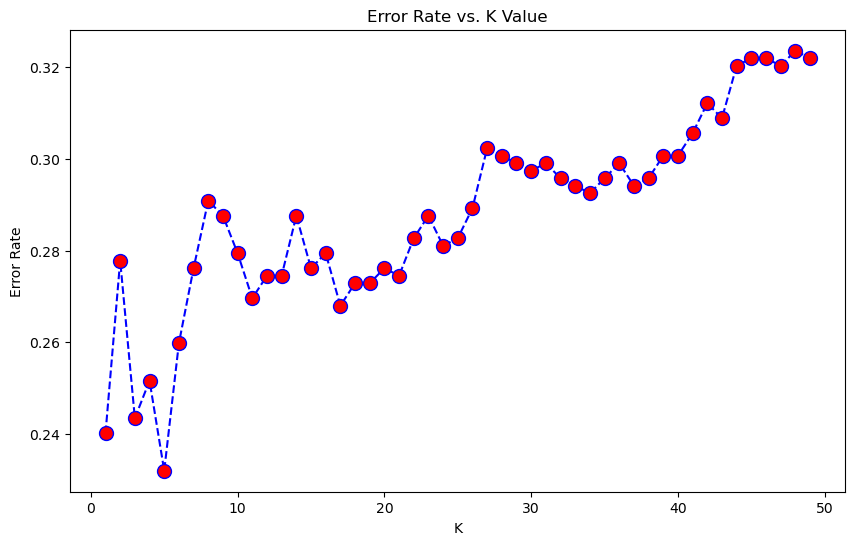

In [76]:
plt.figure(figsize=(10,6))
plt.plot(range(1,50),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [77]:

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,y_train)
Kpred = knn.predict(X_test)
print(classification_report(y_test,Kpred))

              precision    recall  f1-score   support

           0       0.76      0.80      0.78       310
           1       0.78      0.74      0.76       302

    accuracy                           0.77       612
   macro avg       0.77      0.77      0.77       612
weighted avg       0.77      0.77      0.77       612



/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [78]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, Kpred, pos_label=1)
metrics.auc(fpr, tpr)

0.7675923947874386

#### DECISION TREES

In [79]:
dectree = DecisionTreeClassifier()
dectree.fit(X_train,y_train)
tree_pred = dectree.predict(X_test)
print(classification_report(y_test,tree_pred))

              precision    recall  f1-score   support

           0       0.85      0.84      0.85       310
           1       0.84      0.85      0.84       302

    accuracy                           0.84       612
   macro avg       0.84      0.84      0.84       612
weighted avg       0.84      0.84      0.84       612



In [80]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, tree_pred, pos_label=1)
metrics.auc(fpr, tpr)

0.8448515274513994

#### RANDOM FOREST

In [81]:
forestmodel = RandomForestClassifier(n_estimators=100)
forestmodel.fit(X_train, y_train)
forest_pred = forestmodel.predict(X_test)
print(classification_report(y_test,forest_pred))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       310
           1       0.91      0.89      0.90       302

    accuracy                           0.90       612
   macro avg       0.90      0.90      0.90       612
weighted avg       0.90      0.90      0.90       612



In [82]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, forest_pred, pos_label=1)
metrics.auc(fpr, tpr)

0.8985473189489426

#### SUPPORT VECTOR MACHINES

In [84]:
SVmodel = SVC()
SVmodel.fit(X_train,y_train)
SV_pred = SVmodel.predict(X_test)
print(classification_report(y_test,SV_pred))

              precision    recall  f1-score   support

           0       0.66      0.53      0.59       310
           1       0.60      0.73      0.66       302

    accuracy                           0.62       612
   macro avg       0.63      0.63      0.62       612
weighted avg       0.63      0.62      0.62       612



In [85]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, SV_pred, pos_label=1)
metrics.auc(fpr, tpr)

0.6254860072634053

#### Parameter Tuning

In [87]:
param_grid = {'C': [0.0001,0.001,0.01,0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001, 0.00001, 0.000001, 0.0000001], 'kernel': ['rbf']} 

In [88]:
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=3)

In [89]:
grid.fit(X_train,y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END .....C=0.0001, gamma=1, kernel=rbf;, score=0.503 total time=   0.2s
[CV 2/5] END .....C=0.0001, gamma=1, kernel=rbf;, score=0.505 total time=   0.1s
[CV 3/5] END .....C=0.0001, gamma=1, kernel=rbf;, score=0.502 total time=   0.1s
[CV 4/5] END .....C=0.0001, gamma=1, kernel=rbf;, score=0.502 total time=   0.1s
[CV 5/5] END .....C=0.0001, gamma=1, kernel=rbf;, score=0.502 total time=   0.1s
[CV 1/5] END ...C=0.0001, gamma=0.1, kernel=rbf;, score=0.503 total time=   0.1s
[CV 2/5] END ...C=0.0001, gamma=0.1, kernel=rbf;, score=0.505 total time=   0.1s
[CV 3/5] END ...C=0.0001, gamma=0.1, kernel=rbf;, score=0.502 total time=   0.1s
[CV 4/5] END ...C=0.0001, gamma=0.1, kernel=rbf;, score=0.502 total time=   0.1s
[CV 5/5] END ...C=0.0001, gamma=0.1, kernel=rbf;, score=0.502 total time=   0.2s
[CV 1/5] END ..C=0.0001, gamma=0.01, kernel=rbf;, score=0.503 total time=   0.1s
[CV 2/5] END ..C=0.0001, gamma=0.01, kernel=rbf

[CV 3/5] END ..C=0.01, gamma=0.0001, kernel=rbf;, score=0.502 total time=   0.1s
[CV 4/5] END ..C=0.01, gamma=0.0001, kernel=rbf;, score=0.502 total time=   0.1s
[CV 5/5] END ..C=0.01, gamma=0.0001, kernel=rbf;, score=0.502 total time=   0.1s
[CV 1/5] END ...C=0.01, gamma=1e-05, kernel=rbf;, score=0.503 total time=   0.1s
[CV 2/5] END ...C=0.01, gamma=1e-05, kernel=rbf;, score=0.505 total time=   0.1s
[CV 3/5] END ...C=0.01, gamma=1e-05, kernel=rbf;, score=0.502 total time=   0.1s
[CV 4/5] END ...C=0.01, gamma=1e-05, kernel=rbf;, score=0.502 total time=   0.1s
[CV 5/5] END ...C=0.01, gamma=1e-05, kernel=rbf;, score=0.502 total time=   0.1s
[CV 1/5] END ...C=0.01, gamma=1e-06, kernel=rbf;, score=0.503 total time=   0.1s
[CV 2/5] END ...C=0.01, gamma=1e-06, kernel=rbf;, score=0.505 total time=   0.1s
[CV 3/5] END ...C=0.01, gamma=1e-06, kernel=rbf;, score=0.502 total time=   0.1s
[CV 4/5] END ...C=0.01, gamma=1e-06, kernel=rbf;, score=0.502 total time=   0.1s
[CV 5/5] END ...C=0.01, gamm

[CV 5/5] END .........C=10, gamma=1, kernel=rbf;, score=0.502 total time=   0.1s
[CV 1/5] END .......C=10, gamma=0.1, kernel=rbf;, score=0.503 total time=   0.1s
[CV 2/5] END .......C=10, gamma=0.1, kernel=rbf;, score=0.505 total time=   0.1s
[CV 3/5] END .......C=10, gamma=0.1, kernel=rbf;, score=0.502 total time=   0.1s
[CV 4/5] END .......C=10, gamma=0.1, kernel=rbf;, score=0.502 total time=   0.2s
[CV 5/5] END .......C=10, gamma=0.1, kernel=rbf;, score=0.502 total time=   0.2s
[CV 1/5] END ......C=10, gamma=0.01, kernel=rbf;, score=0.503 total time=   0.2s
[CV 2/5] END ......C=10, gamma=0.01, kernel=rbf;, score=0.505 total time=   0.2s
[CV 3/5] END ......C=10, gamma=0.01, kernel=rbf;, score=0.502 total time=   0.2s
[CV 4/5] END ......C=10, gamma=0.01, kernel=rbf;, score=0.502 total time=   0.3s
[CV 5/5] END ......C=10, gamma=0.01, kernel=rbf;, score=0.502 total time=   0.2s
[CV 1/5] END .....C=10, gamma=0.001, kernel=rbf;, score=0.503 total time=   0.1s
[CV 2/5] END .....C=10, gamm

[CV 3/5] END ...C=1000, gamma=1e-05, kernel=rbf;, score=0.516 total time=   0.2s
[CV 4/5] END ...C=1000, gamma=1e-05, kernel=rbf;, score=0.526 total time=   0.2s
[CV 5/5] END ...C=1000, gamma=1e-05, kernel=rbf;, score=0.516 total time=   0.2s
[CV 1/5] END ...C=1000, gamma=1e-06, kernel=rbf;, score=0.762 total time=   0.2s
[CV 2/5] END ...C=1000, gamma=1e-06, kernel=rbf;, score=0.737 total time=   0.2s
[CV 3/5] END ...C=1000, gamma=1e-06, kernel=rbf;, score=0.779 total time=   0.2s
[CV 4/5] END ...C=1000, gamma=1e-06, kernel=rbf;, score=0.737 total time=   0.3s
[CV 5/5] END ...C=1000, gamma=1e-06, kernel=rbf;, score=0.698 total time=   0.2s
[CV 1/5] END ...C=1000, gamma=1e-07, kernel=rbf;, score=0.783 total time=   0.3s
[CV 2/5] END ...C=1000, gamma=1e-07, kernel=rbf;, score=0.681 total time=   0.4s
[CV 3/5] END ...C=1000, gamma=1e-07, kernel=rbf;, score=0.754 total time=   0.3s
[CV 4/5] END ...C=1000, gamma=1e-07, kernel=rbf;, score=0.761 total time=   0.3s
[CV 5/5] END ...C=1000, gamm

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06,
                                   1e-07],
                         'kernel': ['rbf']},
             verbose=3)

In [90]:
grid.best_params_

{'C': 1, 'gamma': 1e-07, 'kernel': 'rbf'}

In [91]:
grid.best_estimator_

SVC(C=1, gamma=1e-07)

In [92]:
grid_pred = grid.predict(X_test)

In [93]:
print(confusion_matrix(y_test,grid_pred))

[[251  59]
 [ 90 212]]


In [95]:
print(classification_report(y_test,grid_pred))

              precision    recall  f1-score   support

           0       0.74      0.81      0.77       310
           1       0.78      0.70      0.74       302

    accuracy                           0.76       612
   macro avg       0.76      0.76      0.76       612
weighted avg       0.76      0.76      0.76       612



In [96]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, grid_pred, pos_label=1)
metrics.auc(fpr, tpr)

0.755832087160863

#### Model Evaluation

In [98]:
Result_dict = {'Logistic Regression':[0.78, 0.77, 0.77, 0.77],
              'KNN': [0.77, 0.77, 0.77, 0.76],
              'Decision Trees': [0.84, 0.84, 0.84, 0.84],
              'Random Forest': [0.90, 0.90, 0.90, 0.89],
              'SVM': [0.76, 0.76, 0.76, 0.75]}
              
        

In [99]:
Results_df = pd.DataFrame(Result_dict.values(), index=['Logistic Regression', 'KNN', 'Decision Trees', 'Random Forest', 'SVM'], columns=['Precision', 'Recall', 'F1-Score', 'AUC'])

Text(0.5, 1.0, 'Overview of Model Performance on Data')

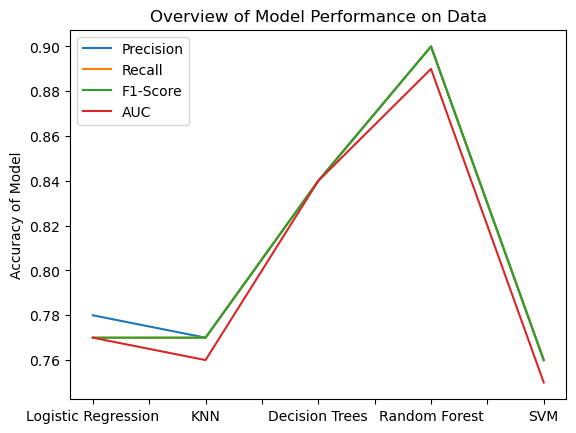

In [100]:
Results_df.plot.line()
plt.ylabel('Accuracy of Model')
plt.title('Overview of Model Performance on Data')

Text(0.5, 1.0, 'Overview of Model Performance on Data')

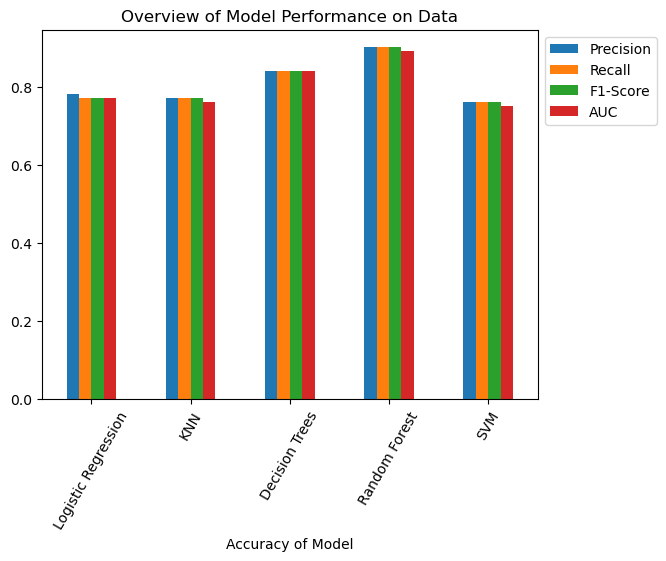

In [101]:
Results_df.plot.bar()
plt.xlabel('Accuracy of Model')
plt.xticks(rotation= 60)
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.title('Overview of Model Performance on Data')

## GRAPHICAL NEURAL NETWORKS

In [113]:
dt

,pixel_feat,pre_hor,pre_ver,ed_sobel,can,contrast,dissimilarity,homogeneity,energy,correlation,...,major_length,minor_length,perimeter,mean,var,std,skewness,kurtosis,SNR,result
0,1030,178,94,196,0,1819,1619,709,454,1361,...,460.966291,447.168033,0,0.782071,0.016637,0.128984,-0.576950,-1.489935,1246,0
1,1369,177,94,221,0,1669,1712,310,150,664,...,552.123811,507.808152,0,0.806557,0.006167,0.078531,-0.717294,-0.601939,59,0
2,1351,299,94,93,0,1259,1061,1099,1984,680,...,553.814157,468.814133,0,0.810320,0.008563,0.092535,-0.643791,-1.175462,1770,0
3,1087,22,94,119,0,1866,1863,184,1510,1061,...,498.810061,471.558365,0,0.772763,0.011784,0.108556,-1.107824,0.096908,1412,0
4,1698,277,94,123,0,2013,2021,16,937,1674,...,521.848816,519.809535,0,0.811999,0.021339,0.146079,-0.673991,-1.000614,1184,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2033,839,269,94,8,0,498,598,1250,989,1077,...,586.271263,488.942082,0,0.802276,0.001460,0.038210,-1.089751,0.729422,1081,1
2034,301,269,94,8,0,324,307,1689,1836,411,...,660.841893,506.649238,0,0.701616,0.003064,0.055351,-0.796670,-0.427353,529,1
2035,894,176,46,258,0,0,2029,23,36,862,...,511.923353,437.789109,0,0.816342,0.010964,0.104710,-0.333472,-0.704867,1553,1
2036,1928,32,94,19,0,1627,1481,643,1195,1695,...,622.919308,493.692567,0,0.894526,0.008316,0.091190,-0.682384,-1.014448,1992,1
